# Estimating ECM Parameters & Running a Thermal Submodel in PyBaMM

This notebook provides example usage for estimating stationary parameters for a two RC branch Thevenin model. With the estimated parameters, a thermal model in PyBaMM is set up.

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP from its development branch and upgrade some dependencies:

In [ ]:
%pip install --upgrade pip ipywidgets
%pip install pybop -q
%pip install pandas --upgrade
%pip install openpyxl

### Importing Libraries

With the environment set up, we can now import PyBOP alongside other libraries we will need:

In [ ]:
import numpy as np
import pandas as pd
import pybamm
import openpyxl
import pybop

In this example, we use the default parameter value for the "Open-circuit voltage [V] as provided by the original PyBaMM class. To update this, provide a function definition that matches this [function](https://github.com/pybamm-team/PyBaMM/blob/1943aa5ab2895b5378220595923dbae3d66b13c9/pybamm/input/parameters/ecm/example_set.py#L17).

In [ ]:
# Load the parameters
parameter_set = pybamm.ParameterValues("ECM_Example")

In [ ]:
# Update the ECM input parameter as required for the present case
parameter_set["Cell capacity [A.h]"] = 3
parameter_set["Nominal cell capacity [A.h]"] = 3
parameter_set["Element-1 initial overpotential [V]"] = 0
parameter_set["Upper voltage cut-off [V]"] = 4.2
parameter_set["Lower voltage cut-off [V]"] = 2.5
parameter_set["R0 [Ohm]"] = 0.001
parameter_set["R1 [Ohm]"] = 0.003
parameter_set["C1 [F]"] = 500
parameter_set.update({"R2 [Ohm]": 0.002}, check_already_exists=False)
parameter_set.update({"C2 [F]": 3000}, check_already_exists=False)
parameter_set.update(
    {"Element-2 initial overpotential [V]": 0}, check_already_exists=False
)
parameter_set.update(
    {
        "Open-circuit voltage [V]": pybop.empirical.Thevenin().default_parameter_values[
            "Open-circuit voltage [V]"
        ]
    },
    check_already_exists=False,
)

## Identifying the Parameters

Now that the initial parameter set is constructed, we can start the PyBOP fitting process. First, we define the model class with two RC elements.

In [ ]:
model = pybop.empirical.Thevenin(
    parameter_set=parameter_set,
    options={"number of rc elements": 2},
    solver=pybamm.CasadiSolver(mode="safe", dt_max=10),
)

We use a single HPPC pulse from the dataset: Kollmeyer, Phillip; Skells, Michael (2020), “Samsung INR21700 30T 3Ah Li-ion Battery Data”, Mendeley Data, V1, doi: 10.17632/9xyvy2njj3.1 

In [ ]:
file_loc = r"../data/Samsung_INR21700/sample_hppc_pulse.xlsx"
df = pd.read_excel(file_loc, index_col=None, na_values=["NA"])
df = df.drop_duplicates(subset=["Time"], keep="first")

dataset = pybop.Dataset(
    {
        "Time [s]": df["Time"].to_numpy(),
        "Current function [A]": df["Current"].to_numpy(),
        "Voltage [V]": df["Voltage"].to_numpy(),
    }
)
r0_guess = 0.005

In [ ]:
parameters = pybop.Parameters(
    pybop.Parameter(
        "R0 [Ohm]",
        prior=pybop.Gaussian(r0_guess, r0_guess / 10),
        bounds=[0, 0.1],
    ),
    pybop.Parameter(
        "R1 [Ohm]",
        prior=pybop.Gaussian(r0_guess, r0_guess / 10),
        bounds=[0, 0.1],
    ),
    pybop.Parameter(
        "R2 [Ohm]",
        prior=pybop.Gaussian(r0_guess, r0_guess / 10),
        bounds=[0, 0.1],
    ),
    pybop.Parameter(
        "C1 [F]",
        prior=pybop.Gaussian(500, 100),
        bounds=[100, 1000],
    ),
    pybop.Parameter(
        "C2 [F]",
        prior=pybop.Gaussian(2000, 500),
        bounds=[1000, 10000],
    ),
)

The `FittingProblem` class provides us with a single class that holds all of the objects we need to evaluate our selected `SumSquaredError` cost function. 

In [ ]:
problem = pybop.FittingProblem(
    model,
    parameters,
    dataset,
    initial_state={"Initial open-circuit voltage [V]": df["Voltage"].to_numpy()[0]},
)

cost = pybop.SumSquaredError(problem)

The cost function can be interrogated manually via the `cost([params])` API. In this example, that would look like the following,

In [ ]:
cost([0.001, 0.001, 0.001, 5000, 5000])

0.20825614088511984

Next, we construct the optimisation class with our algorithm of choice and run it. In this case, we select the CMA-ES method as it provides global optimisation capability. For the sake of reducing the runtime of this example, we limit the maximum iterations to 100; however, feel free to update this value.

In [ ]:
optim = pybop.CMAES(cost, max_unchanged_iterations=50, max_iterations=300)
x, final_cost = optim.run()
print("Initial parameters:", optim.x0)
print("Estimated parameters:", x)

Initial parameters: [5.13981638e-03 4.87114818e-03 5.19066234e-03 4.49686438e+02
 2.41109546e+03]
Estimated parameters: [9.95196711e-03 5.20421160e-03 6.19842496e-02 4.49690742e+02
 2.41113127e+03]


## Plotting and Visualisation

PyBOP provides various plotting utilities to visualize the results of the optimisation.

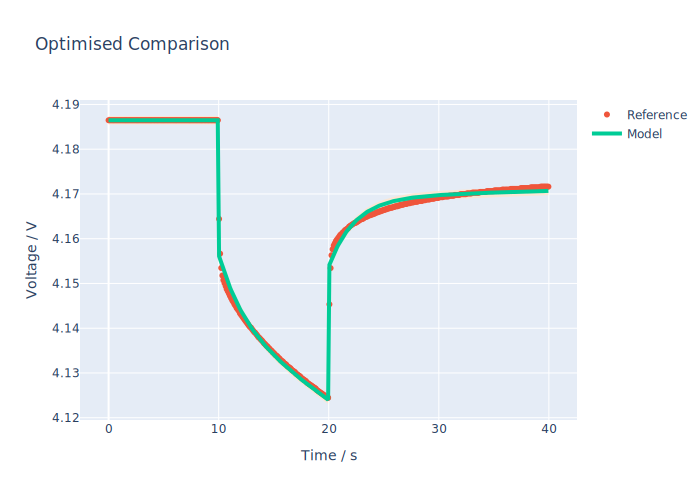

In [ ]:
pybop.quick_plot(problem, problem_inputs=x, title="Optimised Comparison");

### Convergence and Parameter Trajectories

To assess the optimisation process, we can plot the convergence of the cost function and the trajectories of the parameters:

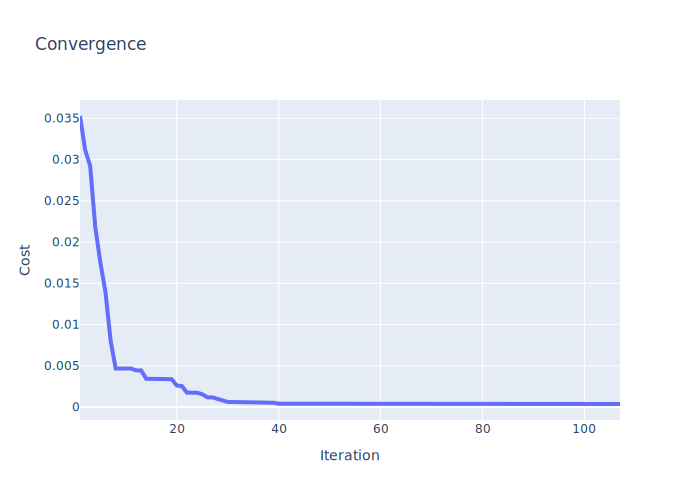

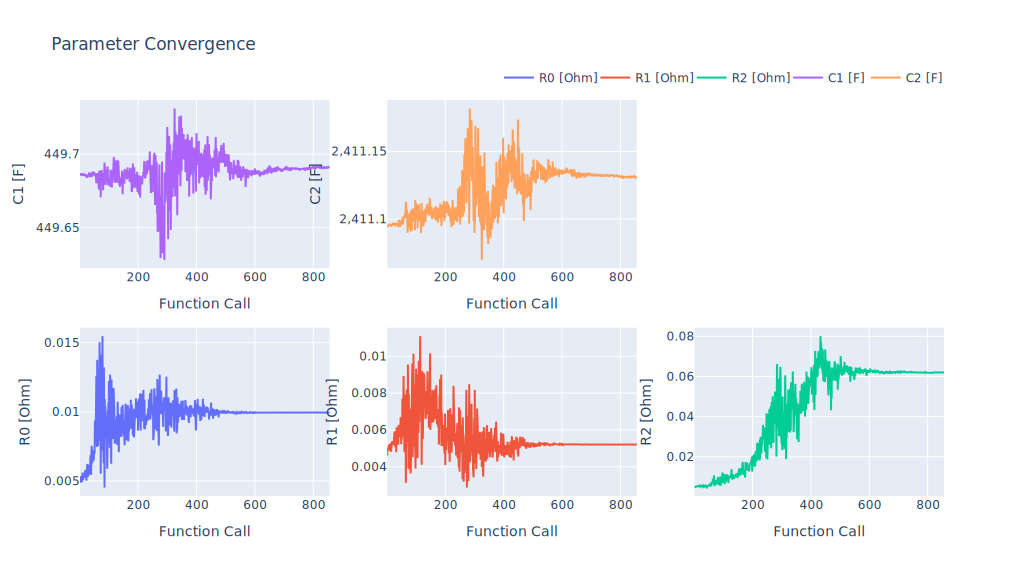

In [ ]:
pybop.plot_convergence(optim)
pybop.plot_parameters(optim);

# Setting up Thermal Submodel
With the estimated RC parameters, the temperature distribution for a given drive cycle can be calculated using ECM model in PyBaMM.

# Import drive cycle
We now use a xlsx file containing current vs time data as a drive cycle. A sample file is used here. User may chose to upload customized drive cycle.

In [ ]:
file_loc = r"../data/Samsung_INR21700/sample_drive_cycle.xlsx"
df = pd.read_excel(file_loc, sheet_name="Sheet3", index_col=None, na_values=["NA"])
df = df.drop_duplicates(subset=["Time"], keep="first")

time = df["Time"].to_numpy()
time = time - time[0]
current = df["Current"].to_numpy()

drive_cycle_current = np.column_stack([time, current])
# Ensuring there is no nan value in the data
drive_cycle_current = drive_cycle_current[~np.isnan(drive_cycle_current).any(axis=1)]
experiment = pybamm.Experiment([pybamm.step.current(drive_cycle_current)])

Update the estimated RC values. These values will be used to estimate heat generation and in turn temperature distribution in the thermal submodel. The thermal submodel is also set up.

In [ ]:
# from convertToPybamm import read_json_to_dict
model = pybamm.equivalent_circuit.Thevenin(options={"number of rc elements": 2})
parameter_set["R0 [Ohm]"] = 9.90845937e-03
parameter_set["R1 [Ohm]"] = 3.91598671e-03
parameter_set["C1 [F]"] = 3.81881833e02
parameter_set["Initial SoC"] = 0.95
parameter_set.update({"R2 [Ohm]": 2.30211519e-02}, check_already_exists=False)
parameter_set.update({"C2 [F]": 1.67503652e03}, check_already_exists=False)
parameter_set.update(
    {"Element-2 initial overpotential [V]": 0}, check_already_exists=False
)

Setting up the thermal simulation in PyBaMM.

In [ ]:
sim = pybamm.Simulation(model, parameter_values=parameter_set, experiment=experiment)
solution = sim.solve()

2024-08-15 15:44:15.823 - [WARNING] callbacks.on_experiment_infeasible_event(252): 

	Experiment is infeasible: 'event: Minimum SoC' was triggered during 'Step([[   0   10]
 [   1   10]
 [   2   10]
 ...
 [3598   10]
 [3599   10]
 [3600   10]], duration=3600, period=1, direction=Discharge)'. The returned solution only contains up to step 1 of cycle 1. 


Visualization of voltage response and cell temperature over time.

In [ ]:
solution.plot(["Battery voltage [V]", "Cell temperature [K]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=2021.9888283578707, step=20.219888283578708)…

### Conclusion

This notebook illustrates how to extract EC parameters from an HPPC pulse using CMA-ES in PyBOP, providing insights into the optimisation process through various visualisations. The estimated parameters are then used to run a thermal submodel using PyBaMM.